## Benchmarking using SemHash on NLU Evaluation Corpora

This notebook benchmarks the results on the 3 NLU Evaluation Corpora:
1. Ask Ubuntu Corpus
2. Chatbot Corpus
3. Web Application Corpus


More information about the dataset is available here: 

https://github.com/sebischair/NLU-Evaluation-Corpora


* Semantic Hashing is used as a featurizer. The idea is taken from the paper:

https://www.microsoft.com/en-us/research/publication/learning-deep-structured-semantic-models-for-web-search-using-clickthrough-data/

* Benchmarks are performed on the same train and test datasets used by the other benchmarks performed in the past. One important paper that benchmarks the datasets mentioned above on some important platforms (Dialogflow, Luis, Watson and RASA) is : 

http://workshop.colips.org/wochat/@sigdial2017/documents/SIGDIAL22.pdf

* Furthermore, Botfuel made another benchmarks with more platforms (Recast, Snips and their own) and results can be found here: 

https://github.com/Botfuel/benchmark-nlp-2018

* The blogposts about the benchmarks done in the past are available at : 

https://medium.com/botfuel/benchmarking-intent-classification-services-june-2018-eb8684a1e55f

https://medium.com/snips-ai/an-introduction-to-snips-nlu-the-open-source-library-behind-snips-embedded-voice-platform-b12b1a60a41a

* To be very fair on our benchmarks and results, we used the same train and test set used by the other benchmarks and no cross validation or stratified splits were used. The test data was not used in any way to improve the results. The dataset used can be found here:

https://github.com/Botfuel/benchmark-nlp-2018/tree/master/results



In [1]:
%matplotlib inline
# import os
# os.environ['LDFLAGS'] = '-framework CoreFoundation -framework SystemConfiguration'
# !pip3 install spacy
import sys
print(sys.path)

['C:\\Users\\pedalo\\Documents\\anaconda3\\envs\\nlp_course\\python36.zip', 'C:\\Users\\pedalo\\Documents\\anaconda3\\envs\\nlp_course\\DLLs', 'C:\\Users\\pedalo\\Documents\\anaconda3\\envs\\nlp_course\\lib', 'C:\\Users\\pedalo\\Documents\\anaconda3\\envs\\nlp_course', '', 'C:\\Users\\pedalo\\Documents\\anaconda3\\envs\\nlp_course\\lib\\site-packages', 'C:\\Users\\pedalo\\Documents\\anaconda3\\envs\\nlp_course\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\pedalo\\.ipython']


In [2]:
#coding: utf-8
from __future__ import unicode_literals
import re
import os
import codecs
import json
import csv
import spacy
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn import model_selection
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors.nearest_centroid import NearestCentroid
import math
import random
from tqdm import tqdm
from nltk.corpus import wordnet
import timeit
import gc
# import locale
# print(locale.getlocale())


Spacy english dataset with vectors needs to be present. It can be downloaded using the following command:

python -m spacy download en_core_web_lg

In [3]:
import spacy
# !python -m spacy download en_core_web_lg
nlp=spacy.load('en_core_web_lg')


In [4]:
nouns = {x.name().split('.', 1)[0] for x in wordnet.all_synsets('n')}
verbs = {x.name().split('.', 1)[0] for x in wordnet.all_synsets('v')}

def get_synonyms(word, number= 3):
    synonyms = []
    for syn in wordnet.synsets(word): 
        for l in syn.lemmas(): 
            synonyms.append(l.name().lower().replace("_", " "))
    synonyms = list(OrderedDict.fromkeys(synonyms))
    return synonyms[:number]
    #return [token.text for token in most_similar(nlp.vocab[word])]

In [5]:
print(get_synonyms("search",-1))

['search', 'hunt', 'hunting', 'lookup', 'seek', 'look for', 'look', 'research']


In [71]:
#Hyperparameters
benchmark_dataset = 'AskUbuntu' # Choose from 'AskUbuntu', 'Chatbot' or 'WebApplication'
oversample = True             # Whether to oversample small classes or not. True in the paper
synonym_extra_samples = False # Whether to replace words by synonyms in the oversampled samples. True in the paper
augment_extra_samples = True  # Whether to add random spelling mistakes in the oversampled samples. False in the paper
additional_synonyms = 0       # How many extra synonym augmented sentences to add for each sentence. 0 in the paper
additional_augments = 0       # How many extra spelling mistake augmented sentences to add for each sentence. 0 in the paper
mistake_distance = 2.1        # How far away on the keyboard a mistake can be


In [72]:
if benchmark_dataset == "Chatbot":
    intent_dict = {"DepartureTime":0, "FindConnection":1}
elif benchmark_dataset == "AskUbuntu":
    intent_dict = {"Make Update":0, "Setup Printer":1, "Shutdown Computer":2, "Software Recommendation":3, "None":4}
elif benchmark_dataset == "WebApplication":
    intent_dict = {"Download Video":0, "Change Password":1, "None":2, "Export Data":3, "Sync Accounts":4,
                  "Filter Spam":5, "Find Alternative":6, "Delete Account":7}

In [73]:
filename_train = "datasets/KL/" + benchmark_dataset + "/train.csv"
filename_test = "datasets/KL/" + benchmark_dataset + "/test.csv"

In [74]:
def read_CSV_datafile(filename):    
    X = []
    y = []
    with open(filename,'r') as csvfile:
        reader = csv.reader(csvfile, delimiter='\t')
        for row in reader:
            X.append(row[0])
            if benchmark_dataset == 'AskUbuntu':
                 y.append(intent_dict[row[1]])
            elif benchmark_dataset == 'Chatbot':
                y.append(intent_dict[row[1]])
            else:
                y.append(intent_dict[row[1]])           
    return X,y


In [75]:
def tokenize(doc):
    """
    Returns a list of strings containing each token in `sentence`
    """
    #return [i for i in re.split(r"([-.\"',:? !\$#@~()*&\^%;\[\]/\\\+<>\n=])",
    #                            doc) if i != '' and i != ' ' and i != '\n']
    tokens = []
    doc = nlp.tokenizer(doc)
    for token in doc:
        tokens.append(token.text)
    return tokens



In [76]:
def preprocess(doc):
    clean_tokens = []
    doc = nlp(doc)
    for token in doc:
        if not token.is_stop:
            clean_tokens.append(token.lemma_)
    return " ".join(clean_tokens)

In [77]:
#********* Data augmentation part **************
class MeraDataset():
    """ Class to find typos based on the keyboard distribution, for QWERTY style keyboards
    
        It's the actual test set as defined in the paper that we comparing against."""

    def __init__(self, dataset_path):
        """ Instantiate the object.
            @param: dataset_path The directory which contains the data set."""
        self.dataset_path = dataset_path
        self.X_test, self.y_test, self.X_train, self.y_train = self.load()
        self.keyboard_cartesian = {'q': {'x': 0, 'y': 0}, 'w': {'x': 1, 'y': 0}, 'e': {'x': 2, 'y': 0},
                                   'r': {'x': 3, 'y': 0}, 't': {'x': 4, 'y': 0}, 'y': {'x': 5, 'y': 0},
                                   'u': {'x': 6, 'y': 0}, 'i': {'x': 7, 'y': 0}, 'o': {'x': 8, 'y': 0},
                                   'p': {'x': 9, 'y': 0}, 'a': {'x': 0, 'y': 1}, 'z': {'x': 0, 'y': 2},
                                   's': {'x': 1, 'y': 1}, 'x': {'x': 1, 'y': 2}, 'd': {'x': 2, 'y': 1},
                                   'c': {'x': 2, 'y': 2}, 'f': {'x': 3, 'y': 1}, 'b': {'x': 4, 'y': 2},
                                   'm': {'x': 6, 'y': 2}, 'j': {'x': 6, 'y': 1}, 'g': {'x': 4, 'y': 1},
                                   'h': {'x': 5, 'y': 1}, 'j': {'x': 6, 'y': 1}, 'k': {'x': 7, 'y': 1},
                                   'l': {'x': 8, 'y': 1}, 'v': {'x': 3, 'y': 2}, 'n': {'x': 5, 'y': 2},
                                   'ß': {'x': 10,'y': 2}, 'ü': {'x': 10,'y': 2}, 'ä': {'x': 10,'y': 0},
                                   'ö': {'x': 11,'y': 0}}
        self.nearest_to_i = self.get_nearest_to_i(self.keyboard_cartesian)
        self.splits = self.stratified_split()


    def get_nearest_to_i(self, keyboard_cartesian):
        """ Get the nearest key to the one read.
            @params: keyboard_cartesian The layout of the QWERTY keyboard for English
            
            return dictionary of eaculidean distances for the characters"""
        nearest_to_i = {}
        for i in keyboard_cartesian.keys():
            nearest_to_i[i] = []
            for j in keyboard_cartesian.keys():
                if self._euclidean_distance(i, j) < mistake_distance: #was > 1.2
                    nearest_to_i[i].append(j)
        return nearest_to_i

    def _shuffle_word(self, word, cutoff=0.7):
        """ Rearange the given characters in a word simulating typos given a probability.
        
            @param: word A single word coming from a sentence
            @param: cutoff The cutoff probability to make a change (default 0.9)
            
            return The word rearranged 
            """
        word = list(word.lower())
        if random.uniform(0, 1.0) > cutoff:
            loc = np.random.randint(0, len(word))
            if word[loc] in self.keyboard_cartesian:
                word[loc] = random.choice(self.nearest_to_i[word[loc]])
        return ''.join(word)

    def _euclidean_distance(self, a, b):
        """ Calculates the euclidean between 2 points in the keyboard
            @param: a Point one 
            @param: b Point two
            
            return The euclidean distance between the two points"""
        X = (self.keyboard_cartesian[a]['x'] - self.keyboard_cartesian[b]['x']) ** 2
        Y = (self.keyboard_cartesian[a]['y'] - self.keyboard_cartesian[b]['y']) ** 2
        return math.sqrt(X + Y)

    def _get_augment_sentence(self, sentence):
        return ' '.join([self._shuffle_word(item) for item in sentence.split(' ')])
    
    def _augment_sentence(self, sentence, num_samples):
        """ Augment the dataset of file with a sentence shuffled
            @param: sentence The sentence from the set
            @param: num_samples The number of sentences to genererate
            
            return A set of augmented sentences"""
        sentences = []
        for _ in range(num_samples):
            sentences.append(self._get_augment_sentence(sentence))
        sentences = list(set(sentences))
        # print("sentences", sentences)
        return sentences + [sentence]

    def _augment_split(self, X_train, y_train, num_samples=100):
        """ Split the augmented train dataset
            @param: X_train The full array of sentences
            @param: y_train The train labels in the train dataset
            @param: num_samples the number of new sentences to create (default 1000)
            
            return Augmented training dataset"""
        Xs, ys = [], []
        for X, y in zip(X_train, y_train):
            tmp_x = self._augment_sentence(X, num_samples)
            sample = [[Xs.append(item), ys.append(y)] for item in tmp_x]
#             print(X, y)
#             print(self.augmentedFile+str(self.nSamples)+".csv")
            
        with open(self.augmentedFile+str(self.nSamples)+"Train.csv", 'w', encoding='utf8') as csvFile:
            fileWriter = csv.writer(csvFile, delimiter='\t')
            for i in range(0, len(Xs)-1):
                fileWriter.writerow([Xs[i] + '\t' + ys[i]])
                # print(Xs[i], "\t", ys[i])
                # print(Xs[i])
            # fileWriter.writerows(Xs + ['\t'] + ys)
        return Xs, ys

    # Randomly replaces the nouns and verbs by synonyms
    def _synonym_word(self, word, cutoff=0.5):
        if random.uniform(0, 1.0) > cutoff and len(get_synonyms(word)) > 0 and word in nouns and word in verbs:
            return random.choice(get_synonyms(word))
        return word
    
    # Randomly replace words (nouns and verbs) in sentence by synonyms
    def _get_synonym_sentence(self, sentence, cutoff = 0.5):
        return ' '.join([self._synonym_word(item, cutoff) for item in sentence.split(' ')])

    # For all classes except the largest ones; add duplicate (possibly augmented) samples until all classes have the same size
    def _oversample_split(self, X_train, y_train, synonym_extra_samples = False, augment_extra_samples = False):
        """ Split the oversampled train dataset
            @param: X_train The full array of sentences
            @param: y_train The train labels in the train dataset
        
            return Oversampled training dataset"""
        
        classes = {}
        for X, y in zip(X_train, y_train):
            if y not in classes:
                classes[y] = []
            classes[y].append(X)
            
        max_class_size = max([len(entries) for entries in classes.values()])
        
        Xs, ys = [],[] 
        for y in classes.keys():
            for i in range(max_class_size):
                sentence = classes[y][i % len(classes[y])]
                if i >= len(classes[y]):
                    if synonym_extra_samples:
                        sentence = self._get_synonym_sentence(sentence)
                    if augment_extra_samples:
                        sentence = self._get_augment_sentence(sentence)
                Xs.append(sentence)
                ys.append(y)
                
        with open("./datasets/KL/Chatbot/train_augmented.csv", 'w', encoding='utf8') as csvFile:
            fileWriter = csv.writer(csvFile, delimiter='\t')
            for i in range(0, len(Xs)-1):
                fileWriter.writerow([Xs[i] + '\t' + ys[i]])
               
        return Xs, ys
    
    def _synonym_split(self, X_train, y_train, num_samples=100):
        """ Split the augmented train dataset
            @param: X_train The full array of sentences
            @param: y_train The train labels in the train dataset
            @param: num_samples the number of new sentences to create (default 1000)
            
            return Augmented training dataset"""
        Xs, ys = [], []
        for X, y in zip(X_train, y_train):
            sample = [[Xs.append(self._get_synonym_sentence(X)), ys.append(y)] for item in range(additional_synonyms)]
#             print(X, y)
            
        with open("./datasets/KL/Chatbot/train_augmented.csv", 'w', encoding='utf8') as csvFile:
            fileWriter = csv.writer(csvFile, delimiter='\t')
            for i in range(0, len(Xs)-1):
                fileWriter.writerow([Xs[i] + '\t' + ys[i]])
        return Xs, ys

    def load(self):
        """ Load the file for now only the test.csv, train.csv files hardcoded
        
            return The vector separated in test, train and the labels for each one"""
        with open(self.dataset_path) as csvfile:
            readCSV = csv.reader(csvfile, delimiter='	')
            all_rows = list(readCSV)
#             for i in all_rows:
#                 if i ==  28823:
#                     print(all_rows[i])
            X_test = [a[0] for a in all_rows]
            y_test = [a[1] for a in all_rows]

        with open(self.dataset_path) as csvfile:
            readCSV = csv.reader(csvfile, delimiter='\t')
            all_rows = list(readCSV)
            X_train = [a[0] for a in all_rows]
            y_train = [a[1] for a in all_rows]
        return X_test, y_test, X_train, y_train

    def process_sentence(self, x):
        """ Clean the tokens from stop words in a sentence.
            @param x Sentence to get rid of stop words.
            
            returns clean string sentence"""
        clean_tokens = []
        doc = nlp.tokenizer(x)
        for token in doc:
            if not token.is_stop:
                clean_tokens.append(token.lemma_)
        return " ".join(clean_tokens)

    def process_batch(self, X):
        """See the progress as is coming along.
        
            return list[] of clean sentences"""
        return [self.process_sentence(a) for a in tqdm(X)]

    def stratified_split(self):
        """ Split data whole into stratified test and training sets, then remove stop word from sentences
        
            return list of dictionaries with keys train,test and values the x and y for each one"""
        self.X_train, self.X_test = ([preprocess(sentence) for sentence in self.X_train],[preprocess(sentence) for sentence in self.X_test])
        print(self.X_train)
        if oversample:
            self.X_train, self.y_train = self._oversample_split(self.X_train, self.y_train, synonym_extra_samples, augment_extra_samples)
        if additional_synonyms > 0:
            self.X_train, self.y_train = self._synonym_split(self.X_train, self.y_train, additional_synonyms)
        if additional_augments > 0:
            self.X_train, self.y_train = self._augment_split(self.X_train, self.y_train, additional_augments)

        splits = [{"train": {"X": self.X_train, "y": self.y_train},
                   "test": {"X": self.X_test, "y": self.y_test}}]
        return splits

    def get_splits(self):
        """ Get the splitted sentences
            
            return splitted list of dictionaries"""
        return self.splits
#****************************************************


In [78]:
print("./datasets/KL/" + benchmark_dataset + "/train.csv")
dataset = MeraDataset("./datasets/KL/" + benchmark_dataset + "/train.csv")
print("mera****************************")
splits = dataset.get_splits()
xS_train = []
yS_train = []
for elem in splits[0]["train"]["X"]:
    xS_train.append(elem)
print(xS_train[:5])

for elem in splits[0]["train"]["y"]:
    yS_train.append(intent_dict[elem])
    
print(len(xS_train))


./datasets/KL/AskUbuntu/train.csv
['how to record -PRON- screen ?', 'how can -PRON- highlight or annotate pdf ?', 'be -PRON- worth upgrade from 12.04 lts to 13.04', 'upgrade to 12.04 64 bit', 'how to upgrade ubuntu 14.04.1 to 14.04.2 ?', 'upgrade from ubuntu 14.04 to 15.04', 'how to upgrade from ubuntu 15.04 to 15.10 ?', 'upgrade 12.04 to 12.10 use startup disk', 'how to upgrade from 11.10 to 12.04 when -PRON- have get a problem ?', 'update 11.04 to 12.04 with livecd', 'how to upgrade ubuntu 9.10 to 12.10 via terminal ?', 'how to upgrade from ubuntu 10.10 to 11.04 ?', 'no matter what -PRON- do ubuntu 15.04 do not recognize hp laserjet 1020', 'how to setup hp printer / scanner on ubuntu ?', 'how do -PRON- setup -PRON- hp c4140 printer wirelessly ?', 'how to setup wireless printing from a printer connect via usb on ubuntu server 12.10 ?', 'how can -PRON- install a pantum 2502w laser printer on ubuntu', 'install canon mp560 ubuntu 15.04', 'how to install a brother mfc-5890cn network print

In [79]:
X_train_raw, y_train_raw = read_CSV_datafile(filename = filename_train)
X_test_raw, y_test_raw = read_CSV_datafile(filename = filename_test)
print(y_train_raw[:5])

X_train_raw = xS_train
y_train_raw = yS_train

[4, 4, 0, 0, 0]


In [80]:
print("Training data samples: \n",X_train_raw, "\n\n")

print("Class Labels: \n", y_train_raw, "\n\n")

print("Size of Training Data: {}".format(len(X_train_raw)))

Training data samples: 
 ['how to record -PRON- screen ?', 'how can -PRON- highlight or annotate pdf ?', 'torrent client for the command - line ?', 'hlw to record -prkn- screqn ?', 'how can -pron- highlight or annotate pdf ?', 'torrent client for the command - line ?', 'how tu record -pron- screen ?', 'how cah -pron- highlight or annotate pdf ?', 'torrent client for ehe command - line ?', 'jow tu record -pron- screen ?', 'how cxn -pron- highlight or annotate pcf ?', 'torrdnt client for the command - line ?', 'how ti record -pyon- ssreen ?', 'how san -pron- highiight or annotwte psf ?', 'torrent client for the command - line ?', 'how to record -pron- screen ?', 'how can -pron- highlight är annotate pdf ?', 'be -PRON- worth upgrade from 12.04 lts to 13.04', 'upgrade to 12.04 64 bit', 'how to upgrade ubuntu 14.04.1 to 14.04.2 ?', 'upgrade from ubuntu 14.04 to 15.04', 'how to upgrade from ubuntu 15.04 to 15.10 ?', 'upgrade 12.04 to 12.10 use startup disk', 'how to upgrade from 11.10 to 12.

# SemHash

In [81]:
def find_ngrams(input_list, n):
    return zip(*[input_list[i:] for i in range(n)])

def semhash_tokenizer(text):
    tokens = text.split(" ")
    final_tokens = []
    for unhashed_token in tokens:
        hashed_token = "#{}#".format(unhashed_token)
        final_tokens += [''.join(gram)
                         for gram in list(find_ngrams(list(hashed_token), 3))]
    return final_tokens

def semhash_corpus(corpus):
    new_corpus = []
    for sentence in corpus:
        sentence = preprocess(sentence)
        tokens = semhash_tokenizer(sentence)
        new_corpus.append(" ".join(map(str,tokens)))
    return new_corpus

X_train_raw_no_HD = semhash_corpus(X_train_raw)
X_test_raw_no_HD = semhash_corpus(X_test_raw)

print(timeit.Timer("for x in range(100): semhash_corpus(X_train_raw)", "gc.enable()").timeit())

In [82]:
print(X_train_raw[:5])
print(y_train_raw[:5])

['how to record -PRON- screen ?', 'how can -PRON- highlight or annotate pdf ?', 'torrent client for the command - line ?', 'hlw to record -prkn- screqn ?', 'how can -pron- highlight or annotate pdf ?']
[4, 4, 4, 4, 4]


In [83]:
def get_vectorizer(corpus, preprocessor=None, tokenizer=None):
    vectorizer = CountVectorizer(ngram_range=(2,4),analyzer='char')
    vectorizer.fit(corpus)
    return vectorizer, vectorizer.get_feature_names()

In [84]:
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.utils.extmath import density
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [85]:
def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."


# #############################################################################
# Benchmark classifiers
def benchmark(clf, X_train, y_train, X_test, y_test, target_names,
              print_report=True, feature_names=None, print_top10=False,
              print_cm=True):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    f1_score = metrics.f1_score(y_test, pred, average='weighted')
    
    print("accuracy:   %0.3f" % score)
    #print("Accuracy: %0.3f (+/- %0.3f)" % (score.mean(), score.std() * 2))

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if print_top10 and feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(["Make Update", "Setup Printer", "Shutdown Computer","Software Recommendation", "None"]):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join([feature_names[i] for i in top10]))))
        print()

    if print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred,labels = range(len(target_names)),
                                            target_names=target_names))

    if print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))
    
    with open("./results.csv", 'a', encoding='utf8') as csvFile:
        fileWriter = csv.writer(csvFile, delimiter='\t')
        fileWriter.writerow([benchmark_dataset,str(clf),str(oversample),str(synonym_extra_samples),str(augment_extra_samples),
                             str(additional_synonyms),str(additional_augments), str(mistake_distance), str(score), str(f1_score)])

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time, f1_score

In [86]:
def plot_results(results):
    # make some plots
    indices = np.arange(len(results))

    results = [[x[i] for x in results] for i in range(4)]

    clf_names, score, training_time, test_time = results
    training_time = np.array(training_time) / np.max(training_time)
    test_time = np.array(test_time) / np.max(test_time)

    plt.figure(figsize=(12, 8))
    plt.title("Score")
    plt.barh(indices, score, .2, label="score", color='navy')
    plt.barh(indices + .3, training_time, .2, label="training time",
             color='c')
    plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)

    for i, c in zip(indices, clf_names):
        plt.text(-.3, i, c)

    plt.show()

In [87]:
def data_for_training():
    vectorizer, feature_names = get_vectorizer(X_train_raw_no_HD, preprocessor=preprocess, tokenizer=tokenize)
    
    X_train_no_HD = vectorizer.transform(X_train_raw_no_HD).toarray()
    X_test_no_HD = vectorizer.transform(X_test_raw_no_HD).toarray()
            
    return X_train_no_HD, y_train_raw, X_test_no_HD, y_test_raw, feature_names



In [88]:
X_train_no_HD, y_train, X_test_no_HD, y_test, feature_names = data_for_training()

In [89]:
#     X_train, y_train, X_test, y_test, feature_names = data_for_training()
def ngram_encode(str_test, HD_aphabet, aphabet, n_size): # method for mapping n-gram statistics of a word to an N-dimensional HD vector
    HD_ngram = np.zeros(HD_aphabet.shape[1]) # will store n-gram statistics mapped to HD vector
    full_str = '#' + str_test + '#' # include extra symbols to the string
        
    for il, l in enumerate(full_str[:-(n_size-1)]): # loops through all n-grams
        hdgram = HD_aphabet[aphabet.find(full_str[il]), :] # picks HD vector for the first symbol in the current n-gram
        for ng in range(1, n_size): #loops through the rest of symbols in the current n-gram
            hdgram = hdgram * np.roll(HD_aphabet[aphabet.find(full_str[il+ng]), :], ng) # two operations simultaneously; binding via elementvise multiplication; rotation via cyclic shift
            
        HD_ngram += hdgram # increments HD vector of n-gram statistics with the HD vector for the currently observed n-gram
    
    HD_ngram_norm = np.sqrt(HD_aphabet.shape[1]) * (HD_ngram/ np.linalg.norm(HD_ngram) )  # normalizes HD-vector so that its norm equals sqrt(N)       
    return HD_ngram_norm # output normalized HD mapping



N = 1000 # set the desired dimensionality of HD vectors
n_size=3 # n-gram size
aphabet = 'abcdefghijklmnopqrstuvwxyz#' #fix the alphabet. Note, we assume that capital letters are not in use 
np.random.seed(1) # for reproducibility
HD_aphabet = 2 * (np.random.randn(len(aphabet), N) < 0) - 1 # generates bipolar {-1, +1}^N HD vectors; one random HD vector per symbol in the alphabet

# str='High like a basketball jump' # example string to represent using n-grams

# print(len(ngram_encode(str, HD_aphabet, aphabet, n_size))) # HD_ngram is a projection of n-gram statistics for str to N-dimensional space. It can be used to learn the word embedding
print(X_train_raw[:5])

for i in range(len(X_train_raw)):
     X_train_raw[i] = ngram_encode(X_train_raw[i], HD_aphabet, aphabet, n_size) # HD_ngram is a projection of n-gram statistics for str to N-dimensional space. It can be used to learn the word embedding
print(X_train_raw[:5])
for i in range(len(X_test_raw)):
    X_test_raw[i] = ngram_encode(X_test_raw[i], HD_aphabet, aphabet, n_size)
print(X_test_raw[:5])

print(print(timeit.Timer("for x in range(100): ngram_encode(X_train_raw[i], HD_aphabet, aphabet, n_size)", "gc.enable()").timeit()))

X_train, y_train, X_test, y_test = X_train_raw, y_train_raw, X_test_raw, y_test_raw
print(X_train[:5])

['how to record -PRON- screen ?', 'how can -PRON- highlight or annotate pdf ?', 'torrent client for the command - line ?', 'hlw to record -prkn- screqn ?', 'how can -pron- highlight or annotate pdf ?']
[array([-0.82344964,  0.82344964, -1.29399228,  0.35290699,  1.76453493,
        1.99980626,  0.35290699, -1.52926361,  0.58817831, -0.58817831,
        0.82344964, -1.29399228, -0.82344964, -1.52926361, -0.11763566,
       -0.58817831,  0.11763566,  0.58817831, -0.11763566,  1.05872096,
        0.35290699,  0.82344964, -0.58817831, -1.52926361,  2.23507758,
       -0.58817831,  0.82344964, -1.29399228,  1.05872096, -1.99980626,
       -1.05872096,  1.29399228,  1.05872096, -0.11763566,  0.35290699,
       -0.11763566,  0.82344964,  0.82344964,  1.29399228, -0.58817831,
       -1.29399228, -0.82344964, -0.58817831,  1.52926361,  1.05872096,
        0.82344964, -1.52926361, -1.05872096,  0.11763566,  1.05872096,
       -1.52926361, -1.05872096, -0.35290699, -0.35290699, -1.05872096,
     

       -0.87053485,  0.58035656, -1.74106969, -2.61160454,  1.16071313])]
[array([ 0.14821729,  0.74108646, -0.74108646,  0.44465188,  0.14821729,
       -1.03752104,  0.44465188,  1.03752104, -0.44465188, -1.33395563,
        0.74108646, -0.14821729, -1.33395563,  0.44465188,  1.33395563,
       -0.74108646,  0.44465188, -1.03752104, -0.14821729,  0.74108646,
       -0.14821729, -0.44465188,  0.44465188, -2.51969396,  0.14821729,
       -0.14821729,  0.74108646, -0.14821729,  0.44465188, -0.44465188,
        1.33395563, -1.63039021,  0.74108646,  1.63039021, -1.63039021,
       -0.14821729,  0.14821729, -0.14821729,  1.33395563, -1.63039021,
        1.92682479, -0.14821729, -0.14821729,  0.14821729,  0.74108646,
        1.03752104,  0.44465188,  0.74108646,  0.14821729,  0.74108646,
       -1.33395563, -1.03752104, -0.14821729, -1.92682479,  0.44465188,
       -0.14821729, -1.03752104, -0.74108646,  0.44465188,  0.74108646,
       -0.14821729,  0.14821729,  1.33395563,  0.44465188,  0

       -2.03147135, -0.18467921,  0.18467921,  0.18467921, -0.55403764])]
[array([-0.82344964,  0.82344964, -1.29399228,  0.35290699,  1.76453493,
        1.99980626,  0.35290699, -1.52926361,  0.58817831, -0.58817831,
        0.82344964, -1.29399228, -0.82344964, -1.52926361, -0.11763566,
       -0.58817831,  0.11763566,  0.58817831, -0.11763566,  1.05872096,
        0.35290699,  0.82344964, -0.58817831, -1.52926361,  2.23507758,
       -0.58817831,  0.82344964, -1.29399228,  1.05872096, -1.99980626,
       -1.05872096,  1.29399228,  1.05872096, -0.11763566,  0.35290699,
       -0.11763566,  0.82344964,  0.82344964,  1.29399228, -0.58817831,
       -1.29399228, -0.82344964, -0.58817831,  1.52926361,  1.05872096,
        0.82344964, -1.52926361, -1.05872096,  0.11763566,  1.05872096,
       -1.52926361, -1.05872096, -0.35290699, -0.35290699, -1.05872096,
       -1.29399228, -0.82344964, -0.11763566,  0.58817831,  2.23507758,
       -0.35290699,  0.82344964,  0.11763566,  1.99980626, -1

       -0.87053485,  0.58035656, -1.74106969, -2.61160454,  1.16071313])]


In [90]:
print(X_train_raw)

[array([-0.82344964,  0.82344964, -1.29399228,  0.35290699,  1.76453493,
        1.99980626,  0.35290699, -1.52926361,  0.58817831, -0.58817831,
        0.82344964, -1.29399228, -0.82344964, -1.52926361, -0.11763566,
       -0.58817831,  0.11763566,  0.58817831, -0.11763566,  1.05872096,
        0.35290699,  0.82344964, -0.58817831, -1.52926361,  2.23507758,
       -0.58817831,  0.82344964, -1.29399228,  1.05872096, -1.99980626,
       -1.05872096,  1.29399228,  1.05872096, -0.11763566,  0.35290699,
       -0.11763566,  0.82344964,  0.82344964,  1.29399228, -0.58817831,
       -1.29399228, -0.82344964, -0.58817831,  1.52926361,  1.05872096,
        0.82344964, -1.52926361, -1.05872096,  0.11763566,  1.05872096,
       -1.52926361, -1.05872096, -0.35290699, -0.35290699, -1.05872096,
       -1.29399228, -0.82344964, -0.11763566,  0.58817831,  2.23507758,
       -0.35290699,  0.82344964,  0.11763566,  1.99980626, -1.52926361,
       -1.76453493,  1.99980626, -0.35290699, -0.82344964,  0.5

       -1.59428901, -0.68326672,  0.        , -2.04980015,  0.22775557])]


Evaluating Split 0
gridsearchRF
________________________________________________________________________________
Training: 
GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000900,
            n_jobs=None, oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 60, 70], 'min_samples_leaf': [1, 11]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)


C:\Users\pedalo\Documents\anaconda3\envs\nlp_course\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


train time: 1.498s
test time:  0.006s


C:\Users\pedalo\Documents\anaconda3\envs\nlp_course\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.798
classification report:


C:\Users\pedalo\Documents\anaconda3\envs\nlp_course\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.94      0.86      0.90        37
          Setup Printer       0.87      1.00      0.93        13
      Shutdown Computer       0.59      0.93      0.72        14
Software Recommendation       0.76      0.72      0.74        40
                   None       0.00      0.00      0.00         5

              micro avg       0.80      0.80      0.80       109
              macro avg       0.63      0.70      0.66       109
           weighted avg       0.78      0.80      0.78       109

confusion matrix:
[[32  1  0  4  0]
 [ 0 13  0  0  0]
 [ 0  0 13  1  0]
 [ 2  1  8 29  0]
 [ 0  0  1  4  0]]

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.001,


C:\Users\pedalo\Documents\anaconda3\envs\nlp_course\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.030s
test time:  0.001s
accuracy:   0.789
dimensionality: 1000
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       0.94      0.92      0.93        37
          Setup Printer       0.46      1.00      0.63        13
      Shutdown Computer       0.93      0.93      0.93        14
Software Recommendation       0.96      0.60      0.74        40
                   None       0.33      0.40      0.36         5

              micro avg       0.79      0.79      0.79       109
              macro avg       0.73      0.77      0.72       109
           weighted avg       0.86      0.79      0.80       109

confusion matrix:
[[34  3  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 13  0  1]
 [ 2 10  1 24  3]
 [ 0  2  0  1  2]]

L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     interce

C:\Users\pedalo\Documents\anaconda3\envs\nlp_course\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.064s
test time:  0.001s
accuracy:   0.743
dimensionality: 1000
density: 0.039200

classification report:
                         precision    recall  f1-score   support

            Make Update       0.81      0.95      0.88        37
          Setup Printer       0.52      0.92      0.67        13
      Shutdown Computer       0.82      1.00      0.90        14
Software Recommendation       0.86      0.45      0.59        40
                   None       0.40      0.40      0.40         5

              micro avg       0.74      0.74      0.74       109
              macro avg       0.68      0.74      0.69       109
           weighted avg       0.78      0.74      0.73       109

confusion matrix:
[[35  1  0  1  0]
 [ 1 12  0  0  0]
 [ 0  0 14  0  0]
 [ 7 10  2 18  3]
 [ 0  0  1  2  2]]

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, 

C:\Users\pedalo\Documents\anaconda3\envs\nlp_course\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.091s
test time:  0.001s
accuracy:   0.743
dimensionality: 1000
density: 0.961600

classification report:
                         precision    recall  f1-score   support

            Make Update       0.78      0.97      0.87        37
          Setup Printer       0.79      0.85      0.81        13
      Shutdown Computer       0.70      1.00      0.82        14
Software Recommendation       0.89      0.42      0.58        40
                   None       0.30      0.60      0.40         5

              micro avg       0.74      0.74      0.74       109
              macro avg       0.69      0.77      0.70       109
           weighted avg       0.79      0.74      0.73       109

confusion matrix:
[[36  1  0  0  0]
 [ 2 11  0  0  0]
 [ 0  0 14  0  0]
 [ 8  2  6 17  7]
 [ 0  0  0  2  3]]

Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       ea

C:\Users\pedalo\Documents\anaconda3\envs\nlp_course\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.098s
test time:  0.001s
accuracy:   0.789
dimensionality: 1000
density: 0.988600

classification report:
                         precision    recall  f1-score   support

            Make Update       0.84      0.97      0.90        37
          Setup Printer       0.71      0.77      0.74        13
      Shutdown Computer       0.76      0.93      0.84        14
Software Recommendation       0.86      0.60      0.71        40
                   None       0.43      0.60      0.50         5

              micro avg       0.79      0.79      0.79       109
              macro avg       0.72      0.77      0.74       109
           weighted avg       0.80      0.79      0.78       109

confusion matrix:
[[36  0  0  1  0]
 [ 3 10  0  0  0]
 [ 0  0 13  1  0]
 [ 4  4  4 24  4]
 [ 0  0  0  2  3]]

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_thresho

C:\Users\pedalo\Documents\anaconda3\envs\nlp_course\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.116s
test time:  0.001s
accuracy:   0.798
classification report:
                         precision    recall  f1-score   support

            Make Update       0.88      0.97      0.92        37
          Setup Printer       0.52      1.00      0.68        13
      Shutdown Computer       0.78      1.00      0.88        14
Software Recommendation       1.00      0.55      0.71        40
                   None       0.67      0.40      0.50         5

              micro avg       0.80      0.80      0.80       109
              macro avg       0.77      0.78      0.74       109
           weighted avg       0.86      0.80      0.79       109

confusion matrix:
[[36  1  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 5  9  3 22  1]
 [ 0  2  1  0  2]]

KMeans
________________________________________________________________________________
Training: 
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_d

C:\Users\pedalo\Documents\anaconda3\envs\nlp_course\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.349
classification report:


C:\Users\pedalo\Documents\anaconda3\envs\nlp_course\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.62      0.97      0.76        37
          Setup Printer       0.04      0.15      0.06        13
      Shutdown Computer       0.00      0.00      0.00        14
Software Recommendation       0.00      0.00      0.00        40
                   None       0.00      0.00      0.00         5

              micro avg       0.35      0.35      0.35       109
              macro avg       0.13      0.23      0.16       109
           weighted avg       0.22      0.35      0.26       109

confusion matrix:
[[36  1  0  0  0]
 [11  2  0  0  0]
 [ 1 13  0  0  0]
 [10 30  0  0  0]
 [ 0  5  0  0  0]]

LogisticRegression
________________________________________________________________________________
Training: 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=Non

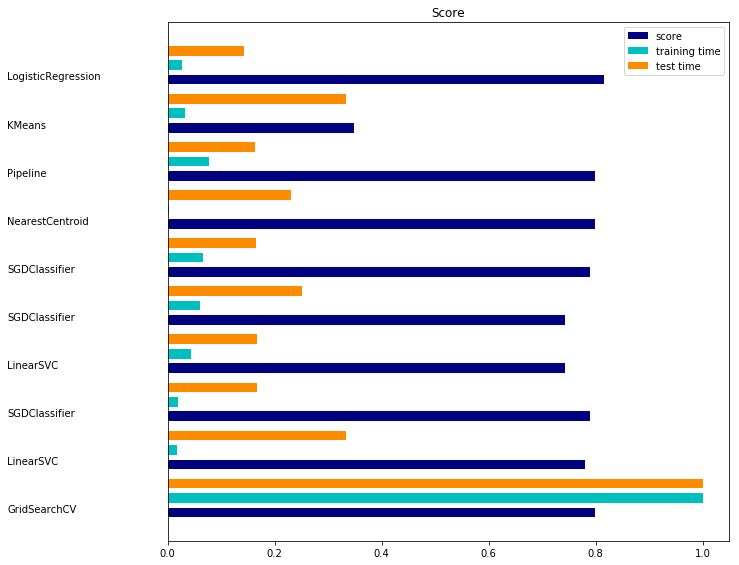

In [91]:
import matplotlib.pyplot as plt
for _ in enumerate(range(1)):
    i_s = 0
    split = 0
    print("Evaluating Split {}".format(i_s))
#     X_train, y_train, X_test, y_test, feature_names = data_for_training()
    target_names = None
    if benchmark_dataset == "Chatbot":
        target_names = ["Departure Time", "Find Connection"]
    elif benchmark_dataset == "AskUbuntu":
        target_names = ["Make Update", "Setup Printer", "Shutdown Computer","Software Recommendation", "None"]
    elif benchmark_dataset == "WebApplication":
        target_names = ["Download Video", "Change Password", "None", "Export Data", "Sync Accounts",
                  "Filter Spam", "Find Alternative", "Delete Account"]
#     print("Train Size: {}\nTest Size: {}".format(X_train.shape[0], X_test.shape[0]))
#     print("Train Size: {}\nTest Size: {}".format(X_train, X_test.shape[0]))
    results = []
    #alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
    parameters_mlp={'hidden_layer_sizes':[(100,50), (300, 100),(300,200,100)]}
    parameters_RF={ "n_estimators" : [50,60,70],
           "min_samples_leaf" : [1, 11]}
    k_range = list(range(3,7))
    parameters_knn = {'n_neighbors':k_range}
    knn=KNeighborsClassifier(n_neighbors=5)
    for clf, name in [  
            #(RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
            #(GridSearchCV(knn,parameters_knn, cv=5),"gridsearchknn"),
            #(Perceptron(n_iter=50), "Perceptron"),
            #(GridSearchCV(MLPClassifier(activation='tanh'),parameters_mlp, cv=5),"gridsearchmlp"),
           # (MLPClassifier(hidden_layer_sizes=(100, 50), activation="logistic", max_iter=300), "MLP"),
            #(MLPClassifier(hidden_layer_sizes=(300, 100, 50), activation="logistic", max_iter=500), "MLP"),
           # (MLPClassifier(hidden_layer_sizes=(300, 100, 50), activation="tanh", max_iter=500), "MLP"),
            #(PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
           # (KNeighborsClassifier(n_neighbors=1), "kNN"),
           # (KNeighborsClassifier(n_neighbors=3), "kNN"),
           # (KNeighborsClassifier(n_neighbors=5), "kNN"),
            #(KNeighborsClassifier(n_neighbors=10), "kNN"),
            (GridSearchCV(RandomForestClassifier(n_estimators=10000900),parameters_RF, cv=5),"gridsearchRF")
            #(RandomForestClassifier(n_estimators=10), "Random forest"),
            #(RandomForestClassifier(n_estimators=50), "Random forest")
    ]:
           
        print('=' * 80)
        print(name)
        result = benchmark(clf, X_train, y_train, X_test, y_test, target_names,
                                 feature_names=feature_names)
        results.append(result)
        
       # print('parameters')
       # print(clf.grid_scores_[0])
        #print('CV Validation Score')
       # print(clf.grid_scores_[0].cv_validation_scores)
       # print('Mean Validation Score')
       # print(clf.grid_scores_[0].mean_validation_score)
       # grid_mean_scores = [result.mean_validation_score for result in clf.grid_scores_]
       # print(grid_mean_scores)
       # plt.plot(k_range, grid_mean_scores)
       # plt.xlabel('Value of K for KNN')
       # plt.ylabel('Cross-Validated Accuracy')

    #parameters_Linearsvc = [{'C': [1, 10], 'gamma': [0.1,1.0]}]
    for penalty in ["l2", "l1"]:
        print('=' * 80)
        print("%s penalty" % penalty.upper())
        # Train Liblinear model
        #grid=(GridSearchCV(LinearSVC,parameters_Linearsvc, cv=10),"gridsearchSVC")
        #results.append(benchmark(LinearSVC(penalty=penalty), X_train, y_train, X_test, y_test, target_names,
                                # feature_names=feature_names))
        
        result = benchmark(LinearSVC(penalty=penalty, dual=False,tol=1e-3),
                                 X_train, y_train, X_test, y_test, target_names,
                                 feature_names=feature_names)
        results.append(result)

        # Train SGD model
        result = benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                               penalty=penalty),
                                 X_train, y_train, X_test, y_test, target_names,
                                 feature_names=feature_names)
        results.append(result)

    # Train SGD with Elastic Net penalty
    print('=' * 80)
    print("Elastic-Net penalty")
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty="elasticnet"),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))

    # Train NearestCentroid without threshold
    print('=' * 80)
    print("NearestCentroid (aka Rocchio classifier)")
    results.append(benchmark(NearestCentroid(),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))

    # Train sparse Naive Bayes classifiers
    print('=' * 80)
    print("Naive Bayes")
    print('Cant do it with negatives from HD!')
#     results.append(benchmark(MultinomialNB(alpha=.01),
#                              X_train, y_train, X_test, y_test, target_names,
#                              feature_names=feature_names))
    
#     result = benchmark(BernoulliNB(alpha=.01),
#                              X_train, y_train, X_test, y_test, target_names,
#                              feature_names=feature_names)
#     results.append(result)

    print('=' * 80)
    print("LinearSVC with L1-based feature selection")
    # The smaller C, the stronger the regularization.
    # The more regularization, the more sparsity.
    
# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
    result = benchmark(Pipeline([
                                  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                                                  tol=1e-3))),
                                  ('classification', LinearSVC(penalty="l2"))]),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names)
    results.append(result)
   # print(grid.grid_scores_)
   #KMeans clustering algorithm 
    print('=' * 80)
    print("KMeans")
    results.append(benchmark(KMeans(n_clusters=2, init='k-means++', max_iter=300,
                verbose=0, random_state=0, tol=1e-4),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))
    
   
    
    print('=' * 80)
    print("LogisticRegression")
    #kfold = model_selection.KFold(n_splits=2, random_state=0)
    #model = LinearDiscriminantAnalysis()
    results.append(benchmark(LogisticRegression(C=1.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))
    
    plot_results(results)
    
    

In [92]:
print(len(X_train))

85
